# 1 - Import des bibliothèques

## 1.1 - Packages python

In [1]:
import os
import sys

## 1.2 - Fonctions créées

In [2]:
chemin_scripts = os.path.abspath(os.path.join(os.getcwd(), '..', 'scripts'))
sys.path.append(chemin_scripts)

from fonctions_conso import importation, clean, traitement_valeurs_manquantes, graph_valeurs_manquantes, stats_desc, graph

# 2 - Import des données de consommation éléctrique

On utilise pour l'instant les données de la métropole du Grand Paris mais on pourra appliquer les fonctions aux autres métropoles. On dispose des données du 1er janvier 2021 à aujourd'hui.

In [3]:
url = "https://odre.opendatasoft.com/api/explore/v2.1/catalog/datasets/eco2mix-metropoles-tr/exports/csv?lang=fr&refine=libelle_metropole%3A%22M%C3%A9tropole%20du%20Grand%20Paris%22&facet=facet(name%3D%22libelle_metropole%22%2C%20disjunctive%3Dtrue)&timezone=Europe%2FParis&use_labels=true&delimiter=%3B"

In [4]:
df_paris = importation(url)

# 3 - Exploration initiale

In [5]:
df_paris.head(1)

,Code métropole,Métropole,Nature,Date,Heures,Date - Heure,Consommation (MW),Production,Echanges physiques
0,200054781,Métropole du Grand Paris,Données temps réel,2023-03-17,22:00,2023-03-17T22:00:00+01:00,3960.0,ND,3781


In [6]:
df_paris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209948 entries, 0 to 209947
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Code métropole      209948 non-null  int64  
 1   Métropole           209948 non-null  object 
 2   Nature              209948 non-null  object 
 3   Date                209948 non-null  object 
 4   Heures              209948 non-null  object 
 5   Date - Heure        209948 non-null  object 
 6   Consommation (MW)   208619 non-null  float64
 7   Production          130946 non-null  object 
 8   Echanges physiques  130946 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 14.4+ MB


In [7]:
nan = df_paris.loc[df_paris['Consommation (MW)'].isna()].shape[0]
zeros = df_paris.loc[df_paris['Consommation (MW)'] == 0].shape[0]

print('La colonne consommation du df comporte ' + str(nan) + ' valeurs manquantes et ' + str(zeros) + 
      ' valeurs nulles.')

La colonne consommation du df comporte 1329 valeurs manquantes et 140 valeurs nulles.


On remarque que :
- les dates sont en format str et non date
- le df n'est pas trié par date
- on a des valeurs manquantes et également des consommations égales à 0
- certaines colonnes ne vont pas nous être utiles

# 4 - Nettoyage des données

## 4.1 - Nettoyage structurel

On renomme les colonnes, convertit en format date, trie par date.

**Attention** : on ne fait pas pd.to_datetime(df['Date - Heure']) directement car Python va normaliser le fuseau horaire spécifié et on n'aura plus l'heure locale mais l'heure par rapport au fuseau horaire 0, ce qui peut fausser l'heure de 2 heures par rapport à l'heure locale.

In [5]:
df_paris_clean = clean(df_paris)

In [9]:
df_paris_clean.tail(2)

,code_met,met,date,heure,conso
date_heure,,,,,
2025-12-25 23:30:00,200054781,Métropole du Grand Paris,2025-12-25,23:30,5049.0
2025-12-25 23:45:00,200054781,Métropole du Grand Paris,2025-12-25,23:45,4965.0


In [10]:
df_paris_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 209852 entries, 2020-01-01 01:00:00 to 2025-12-25 23:45:00
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   code_met  209852 non-null  int64         
 1   met       209852 non-null  object        
 2   date      209852 non-null  datetime64[ns]
 3   heure     209852 non-null  object        
 4   conso     208477 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 9.6+ MB


On remarque que toutes les colonnes sont remplies exceptée la colonne conso qui contient ~1300 valeurs manquantes qu'on va devoir traiter.

## 4.2 - Traitement des valeurs manquantes

En explorant les données manquantes on en remarque plusieurs types :
- les données manquantes "individuelles" : une seule donnée manque
- les données manquantes par plage : toute une période est manquante

On va estimer par interpolation des données manquantes individuelles ou les petites plages de données (16 données au maximum correspondant à 4h de données manquantes). Pour les plages plus importantes (la plus longue étant 90 correspondant à 22h30 de données manquantes), on va essayer de se baser sur les informations historiques.

### 4.2.1 - Reconstruire les valeurs manquantes

In [6]:
df_paris_final = traitement_valeurs_manquantes(df_paris_clean)

### 4.2.2 - Vérification

In [12]:
interp = df_paris_final.loc[(df_paris_final['conso'].isna()) & (~df_paris_final['conso_interp'].isna())].shape[0]
j7 = df_paris_final.loc[(df_paris_final['conso'].isna()) & (df_paris_final['conso_interp'].isna())].shape[0]

print('Sur les ' + str(interp+j7) + ' valeurs manquantes, ' + str(interp) + 
      ' sont associées à de petites plages et ont pu être remplies par interpolation tandis que ' + str(j7) +
      ' données ont du être reconstruites en associant la valeur J-7.')

Sur les 1375 valeurs manquantes, 628 sont associées à de petites plages et ont pu être remplies par interpolation tandis que 747 données ont du être reconstruites en associant la valeur J-7.


In [13]:
df_paris_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 209852 entries, 2020-01-01 01:00:00 to 2025-12-25 23:45:00
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   code_met      209852 non-null  int64         
 1   met           209852 non-null  object        
 2   date          209852 non-null  datetime64[ns]
 3   heure         209852 non-null  object        
 4   conso         208477 non-null  float64       
 5   conso_interp  209105 non-null  float64       
 6   conso_final   209852 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 12.8+ MB


La colonne `conso_final` ne contient plus aucun NaN, comme prévu.

### 4.2.3 - Vérification graphique de la cohérence des valeurs imputées

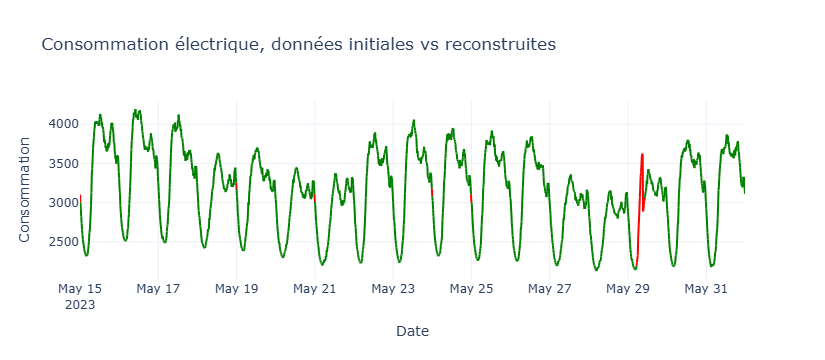

In [14]:
start = "2023-05-15"
end   = "2023-05-31"

graph_valeurs_manquantes (start, end, df_paris_final)

In [15]:
df_paris_final.loc[start:end][1364:1386]

,code_met,met,date,heure,conso,conso_interp,conso_final
date_heure,,,,,,,
2023-05-29 05:00:00,200054781,Métropole du Grand Paris,2023-05-29,05:00,2154.0,2154.000000,2154.000000
2023-05-29 05:15:00,200054781,Métropole du Grand Paris,2023-05-29,05:15,NaN,2197.190476,2197.190476
2023-05-29 05:30:00,200054781,Métropole du Grand Paris,2023-05-29,05:30,NaN,2240.380952,2240.380952
2023-05-29 05:45:00,200054781,Métropole du Grand Paris,2023-05-29,05:45,NaN,2283.571429,2283.571429
2023-05-29 06:00:00,200054781,Métropole du Grand Paris,2023-05-29,06:00,NaN,2326.761905,2326.761905
2023-05-29 06:15:00,200054781,Métropole du Grand Paris,2023-05-29,06:15,NaN,NaN,2550.000000
2023-05-29 06:30:00,200054781,Métropole du Grand Paris,2023-05-29,06:30,NaN,NaN,2680.000000
2023-05-29 06:45:00,200054781,Métropole du Grand Paris,2023-05-29,06:45,NaN,NaN,2780.000000
2023-05-29 07:00:00,200054781,Métropole du Grand Paris,2023-05-29,07:00,NaN,NaN,2907.000000


Les données interpolées paraissent cohérentes. Les données reconstruites via j-7 sont moins fiables : par exemple le pic reconstruit pour le 29 mai 2023 parait peu crédible. 

# 5 - Statistiques descriptives

On va calculer la moyenne, médiane, mode (conso la + fréquente), min, max, amplitude, écart-type, variance, skewness et kurtosis.

In [16]:
display(stats_desc(df_paris_final))

,Moyenne,Médiane,Mode,Min,Max,Amplitude,Écart-type,Variance,Skewness,Kurtosis
Valeur,3973.18,3846.0,3845.0,1974.0,7795.0,5821.0,1050.44,1103429.99,0.53,-0.18


**Interprétation** :
- moyenne = 3973 > médiane = 3846 : distribution plutôt asymétrique avec une queue à droite, présence de valeurs extrêmes tirant la moyenne vers le haut
- amplitude et écart-type élevés indiquent une grande dispersion des données autour de la moyenne
- skewness = 0.53 : la distribution est légèrement étendue à droite, cpnfirmant la présence de grandes valeurs extrêmes
- kurtosis = 0.18 : la distribution est un peu plus plate qu'une distribution normale, la quantité de valeurs extrêmes demeure raisonnable

**Conclusion** : sans doute présence de valeurs extrêmes dans des proportions limitées

# 6 - Visualisations

On peut déjà commencer par représenter notre série telle quelle :

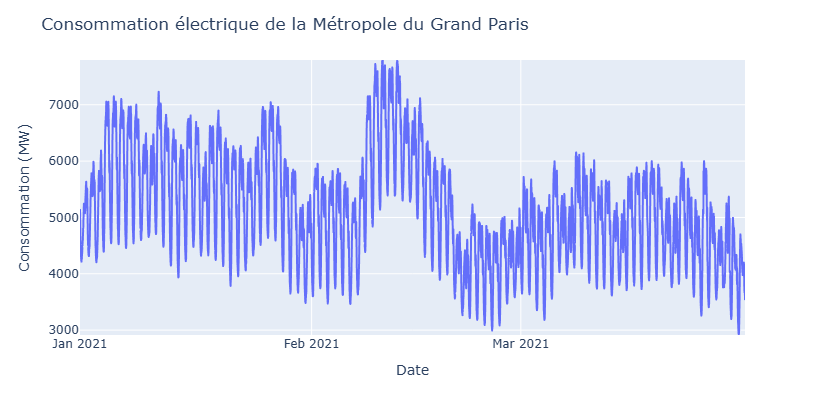

In [61]:
#spécifier date de début et de fin pour le graphe

start = '2021-01-01'
end = '2021-03-31'

graph(start, end, df_paris_final)

On va ensuite affiner nos visualisations afin de détecter déjà certaines choses dans nos données :
- mettre en lumière la tendance générale
- calculer la consommation totale par année et par mois
- représenter l'ampleur de la consommation selon le jour et l'heure par une heatmap
- détecter d'eventuels profils journaliers par catégorie : semaine vs week-end, jours d'été vs jours d'hiver, jour de la semaine

## 6.1 - Tendance de fond

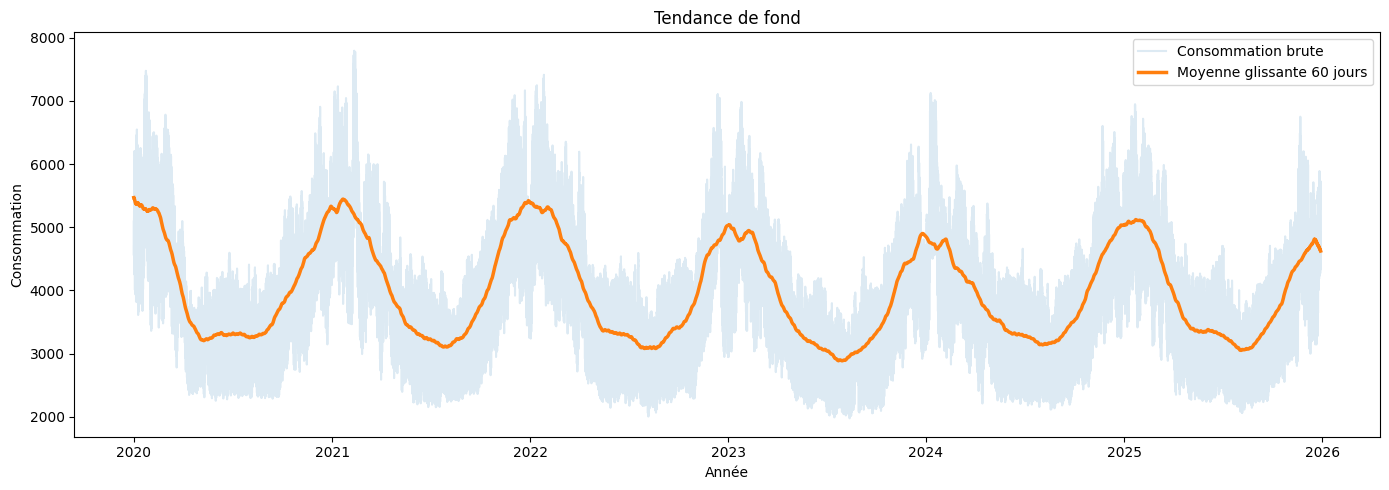

In [60]:
import matplotlib.pyplot as plt

df = df_paris_final[['conso_final']].copy()

window_days = 60
window = window_days * 96  # 96 quarts d'heure / jour

df['rolling_60j'] = df['conso_final'].rolling(window=window, center=True, min_periods=window//2).mean()

plt.figure(figsize=(14,5))
plt.plot(df.index, df['conso_final'], alpha=0.15, label='Consommation brute')
plt.plot(df.index, df['rolling_60j'], linewidth=2.5, label='Moyenne glissante sur 60 jours')

plt.title("Tendance de fond")
plt.xlabel("Année")
plt.ylabel("Consommation")
plt.legend()
plt.tight_layout()
plt.show()

**Interprétation** : on remarque une saisonnalité très forte avec une forte baisse de la consommation en milieu d'année (été) comparativement au début et à la fin de l'année (hiver).

## 6.2 - Consommation totale par mois et par année

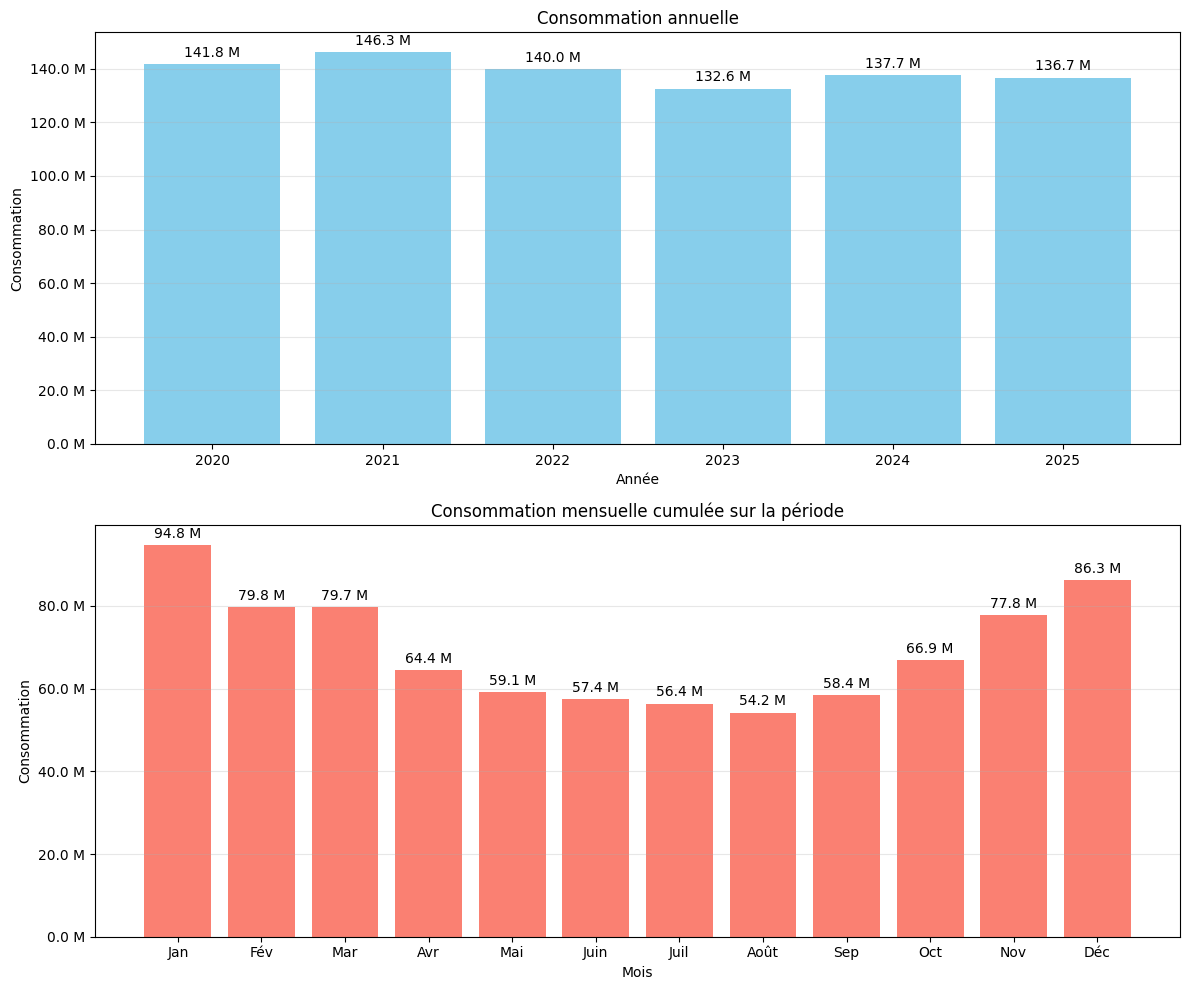

In [54]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

#formatter pour afficher les nombres en millions
def millions(x, pos):
    return f'{x/1e6:.1f} M'

formatter = FuncFormatter(millions)

#conso annuelle
yearly = df['conso_final'].resample('YE').sum()

#conso mensuelle
monthly_sum = df['conso_final'].groupby(df.index.month).sum()
months = ['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Juin', 'Juil', 'Août', 'Sep', 'Oct', 'Nov', 'Déc']

#subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

#graph conso annuelle
bars1 = ax1.bar(yearly.index.year, yearly.values, color='skyblue')
ax1.set_title("Consommation annuelle")
ax1.set_xlabel("Année")
ax1.set_ylabel("Consommation")
ax1.grid(axis='y', alpha=0.3)
ax1.yaxis.set_major_formatter(formatter)
ax1.bar_label(bars1, labels=[f'{v/1e6:.1f} M' for v in yearly.values], padding=3)

#graph conso mensuelle
bars2 = ax2.bar(months, monthly_sum.values, color='salmon')
ax2.set_title("Consommation mensuelle cumulée sur la période")
ax2.set_xlabel("Mois")
ax2.set_ylabel("Consommation")
ax2.grid(axis='y', alpha=0.3)
ax2.yaxis.set_major_formatter(formatter)
ax2.bar_label(bars2, labels=[f'{v/1e6:.1f} M' for v in monthly_sum.values], padding=3)

plt.tight_layout()
plt.show()

**Interprétation**: la saisonnalité déjà évoquée se retrouve dans l'histogramme avec une consommation beaucoup plus faible en juillet et août notamment. Quant à la somme de la consommation par année elle est plutôt stable voire légèrement en baisse.

## 6.3 - Heatmap jour x heure

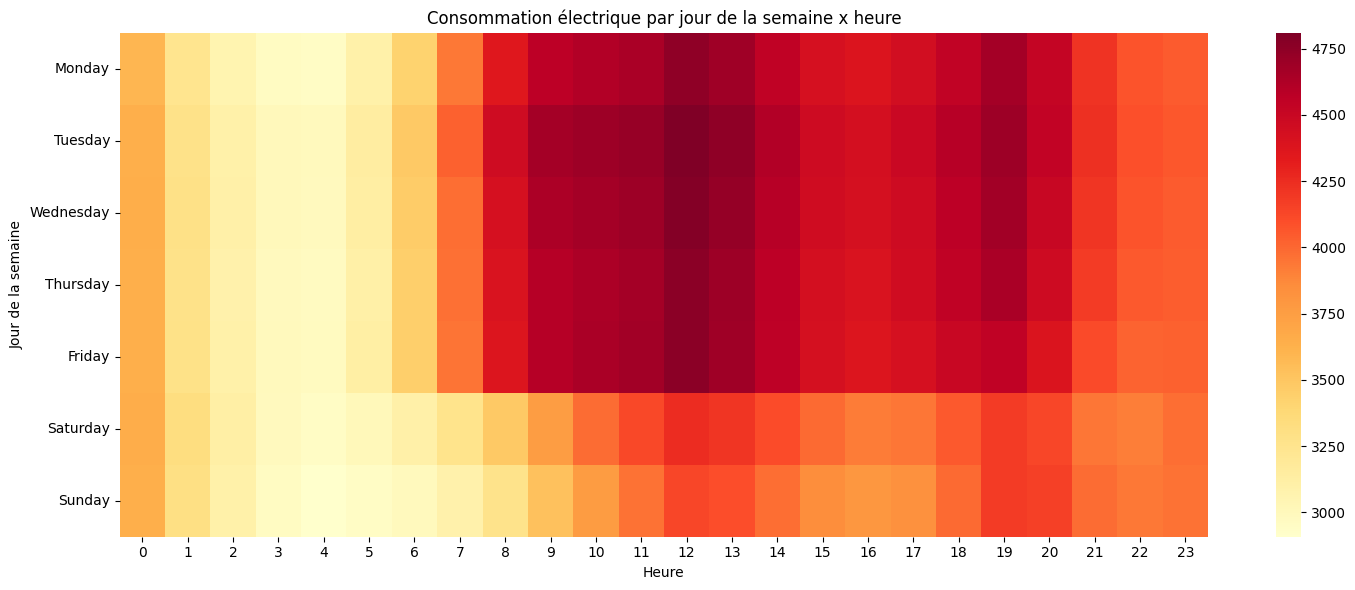

In [59]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#créer des colonnes pour le jour de la semaine et l'heure
df['jour_semaine'] = df.index.day_name() 
df['heure'] = df.index.hour

#ordre des jours
jours_ordre = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

#mise en forme des data
heatmap_data = df.pivot_table(index='jour_semaine', columns='heure', values='conso_final', aggfunc='mean')
heatmap_data = heatmap_data.reindex(jours_ordre)  # remettre dans l'ordre correct

#heatmap
plt.figure(figsize=(15, 6))
sns.heatmap(heatmap_data, cmap='YlOrRd', annot=False)
plt.title("Consommation électrique par jour de la semaine x heure")
plt.xlabel("Heure")
plt.ylabel("Jour de la semaine")
plt.tight_layout()
plt.show()

**Interprétation** : la consommation est sensiblement plus faible entre 1h et 6h du matin quelque soit le jour de la semaine. Le week-end, le début de la hausse de la consommation se fait plus tardivement, aux alentous de 9-10h contre 6-7h en semaine. En semaine on constate un pic de consommation vers 12h puis vers 19h tandis que le week end la consommation est plutôt stable quelque soit l'heure.

## 6.5 - Profils journaliers

- profil journalier moyen par catégorie : semaine vs week end, jours d'été vs jours d'hiver
- profil journalier moyen par jour de la semaine